# analyze_fit_us_data.ipynb

Analyze the curves that [fit_us_data.ipynb](./fit_us_data.ipynb) fit to the COVID-19 time series.

Inputs:
* `outputs/us_counties_curves.csv`: Curves generated by [fit_us_data.ipynb](./fit_us_data.ipynb)
* `outputs/us_counties_curves_meta.json`: Column type metadata for reading `data/us_counties_curves.csv` with `pd.read_csv()`
* `outputs/us_counties_curves_params.csv`: Model parameters corresponding to the curves in `data/us_counties_curves.csv`

**Note:** You can redirect these input files by setting the environment variable `COVID_OUTPUTS_DIR` to a replacement for the prefix `outputs` in the above paths.

In [1]:
# Initialization boilerplate
import os
import json
import pandas as pd
import numpy as np
import scipy.optimize
from sklearn import metrics

from typing import *

import text_extensions_for_pandas as tp

# Local file of utility functions
import util

# Allow environment variables to override data file locations.
_OUTPUTS_DIR = os.getenv("COVID_OUTPUTS_DIR", "outputs")
util.ensure_dir_exists(_OUTPUTS_DIR)  # create if necessary

# Read and reformat input data

## Load the time series data

In [2]:
csv_file = os.path.join(_OUTPUTS_DIR, "us_counties_curves.csv")
meta_file = os.path.join(_OUTPUTS_DIR, "us_counties_curves_meta.json")

# Read column type metadata
with open(meta_file) as f:
    curves_meta = json.load(f)

# Pandas does not currently support parsing datetime64 from CSV files.
# As a workaround, read the "Date" column as objects and manually 
# convert after.
curves_meta["Date"] = "object"

curves_vertical = (
    pd
    .read_csv(csv_file, dtype=curves_meta, parse_dates=["Date"])   
    .set_index(["FIPS", "Date"], verify_integrity=True)
)
curves_vertical

State    County  Population  Confirmed  Confirmed_Outlier  \
FIPS  Date                                                                      
1001  2020-03-10  Alabama   Autauga       55869        0.0              False   
      2020-03-11  Alabama   Autauga       55869        0.0              False   
      2020-03-12  Alabama   Autauga       55869        0.0              False   
      2020-03-13  Alabama   Autauga       55869        0.0              False   
      2020-03-14  Alabama   Autauga       55869        0.0              False   
...                   ...       ...         ...        ...                ...   
56043 2020-09-12  Wyoming  Washakie        7805      111.0              False   
      2020-09-13  Wyoming  Washakie        7805      111.0              False   
      2020-09-14  Wyoming  Washakie        7805      111.0              False   
      2020-09-15  Wyoming  Washakie        7805      111.0              False   
      2020-09-16  Wyoming  Washakie        7805      111.0              False   

                  Exponential    Logistic   Logistic2  
FIPS  Date                                             
1001  2020-03-10     1.000000    9.327762    3.404962  
      2020-03-11     1.041685    9.701171    3.597326  
      2020-03-12     1.085107   10.089433    3.800279  
      2020-03-13     1.130340   10.493131    4.014386  
      2020-03-14     1.177457   10.912869    4.240243  
...                       ...         ...         ...  
56043 2020-09-12   142.736615  118.473003  117.717763  
      2020-09-13   146.594919  119.808891  119.028758  
      2020-09-14   150.557516  121.145390  120.340921  
      2020-09-15   154.627226  122.482182  121.653961  
      2020-09-16   158.806944  123.818947  122.967585  

[457254 rows x 8 columns]

In [3]:
# Name of the column that bgfs.ipynb analyzed
ts_col_name = "Confirmed"
outlier_col_name = ts_col_name + "_Outlier"
metadata_cols = ["State", "County", "Population"]

In [4]:
# As a workaround for a bug in Pandas' extension types system,
# we need to cast the boolean columns to ints.
curves_vertical[outlier_col_name] = curves_vertical[outlier_col_name].astype(np.int8)
curves_vertical

State    County  Population  Confirmed  Confirmed_Outlier  \
FIPS  Date                                                                      
1001  2020-03-10  Alabama   Autauga       55869        0.0                  0   
      2020-03-11  Alabama   Autauga       55869        0.0                  0   
      2020-03-12  Alabama   Autauga       55869        0.0                  0   
      2020-03-13  Alabama   Autauga       55869        0.0                  0   
      2020-03-14  Alabama   Autauga       55869        0.0                  0   
...                   ...       ...         ...        ...                ...   
56043 2020-09-12  Wyoming  Washakie        7805      111.0                  0   
      2020-09-13  Wyoming  Washakie        7805      111.0                  0   
      2020-09-14  Wyoming  Washakie        7805      111.0                  0   
      2020-09-15  Wyoming  Washakie        7805      111.0                  0   
      2020-09-16  Wyoming  Washakie        7805      111.0                  0   

                  Exponential    Logistic   Logistic2  
FIPS  Date                                             
1001  2020-03-10     1.000000    9.327762    3.404962  
      2020-03-11     1.041685    9.701171    3.597326  
      2020-03-12     1.085107   10.089433    3.800279  
      2020-03-13     1.130340   10.493131    4.014386  
      2020-03-14     1.177457   10.912869    4.240243  
...                       ...         ...         ...  
56043 2020-09-12   142.736615  118.473003  117.717763  
      2020-09-13   146.594919  119.808891  119.028758  
      2020-09-14   150.557516  121.145390  120.340921  
      2020-09-15   154.627226  122.482182  121.653961  
      2020-09-16   158.806944  123.818947  122.967585  

[457254 rows x 8 columns]

## Collapse each time series down to a single cell

This kind of time series data is easier to manipulate at the macroscopic level if each time series occupies a 
single cell of the DataFrame. We use the [TensorArray](https://text-extensions-for-pandas.readthedocs.io/en/latest/#text_extensions_for_pandas.TensorArray) Pandas extension type from [Text Extensions for Pandas](https://github.com/CODAIT/text-extensions-for-pandas).

In [5]:
curves, dates = util.collapse_time_series(curves_vertical, [
    ts_col_name, outlier_col_name,
    "Exponential", "Logistic", "Logistic2"])
curves

,State,County,Population,Confirmed,Confirmed_Outlier,Exponential,Logistic,Logistic2
FIPS,,,,,,,,
1001,Alabama,Autauga,55869,[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[1.00000000e+00 1.04168475e+00 1.08510712e+00 1...,[ 9.3277625 9.70117131 10.08943301 10...,[ 3.4049623 3.59732569 3.80027857 4...
1003,Alabama,Baldwin,223234,[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[1.00000000e+00 1.04826447e+00 1.09885840e+00 1...,[6.02295894e-01 6.43023771e-01 6.86505321e-01 7...,[1.22173540e+00 1.38792754e+00 1.57669631e+00 1...
1005,Alabama,Barbour,24686,[ 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[1.00000000e+00 1.03751304e+00 1.07643331e+00 1...,[ 5.14106278 5.36624076 5.60119958 5.846...,[ 3.52948132 3.70469473 3.88851264 4.081...
1007,Alabama,Bibb,22394,[ 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 1. 1.0363871 1.07409823 1.113...,[ 3.62817231 3.76352987 3.90390935 4.049...,[ 2.12465443 2.2390666 2.36069772 2.489...
1009,Alabama,Blount,57826,[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[1.00000000e+00 1.04015703e+00 1.08192664e+00 1...,[1.03695886e+00 1.08948804e+00 1.14467585e+00 1...,[3.53733969e-07 8.00601326e-07 1.81198565e-06 4...
...,...,...,...,...,...,...,...,...
56033,Wyoming,Sheridan,30485,[ 0. 0. 1. 1. 1. 1. 1. 2. 4. ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 1. 1.02891386 1.05866373 1.089...,[ 0.28931852 0.30058574 0.31229143 0.324...,[6.24801328e-02 7.03740355e-02 7.91485934e-02 8...
56037,Wyoming,Sweetwater,42343,[ 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 1. 1.03318945 1.06748045 1.102...,[2.25690612e-01 2.38879574e-01 2.52838680e-01 2...,[8.40025340e-02 9.15547776e-02 9.97357344e-02 1...
56039,Wyoming,Teton,23464,[ 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 1. 1.0352243 1.07168935 1.109...,[ 17.45121528 17.83462298 18.22627629 18.626...,[ 1.06613482 1.10547347 1.14640675 1.189...


## Load the parameters of the curves that `fit_us_data.ipynb` fit

In [6]:
params_data_file = os.path.join(_OUTPUTS_DIR, "us_counties_curves_params.csv")
params = pd.read_csv(params_data_file).set_index("FIPS", verify_integrity=True)
params

,State,County,Population,Exp_Rate,Exp_Offset,Log_Max,Log_Rate,Log_Offset,Log2_Max1,Log2_Rate1,Log2_Offset1,Log2_Max2,Log2_Rate2,Log2_Offset2,Log2_Switch_Begin,Log2_Switch_End
FIPS,,,,,,,,,,,,,,,,
1001,Alabama,Autauga,55869,0.040839,0.0,1590.052584,0.039488,129.980760,1522.318450,0.070265,96.234191,1601.552878,0.042286,134.537067,4.375111,58.299737
1003,Alabama,Baldwin,223234,0.047136,0.0,4865.445687,0.065441,137.479038,513.462631,0.132519,40.848802,6317.543710,0.081696,135.330599,5.131853,190.999465
1005,Alabama,Barbour,24686,0.036827,0.0,679.404448,0.043202,112.873994,561.814750,10.000000,188.706987,921.779486,0.046162,105.029521,0.000000,191.000000
1007,Alabama,Bibb,22394,0.035741,0.0,709.823846,0.036820,143.160423,680.624634,0.041359,143.316933,711.522237,0.036683,143.316788,10.000067,19.999944
1009,Alabama,Blount,57826,0.039372,0.0,1296.922046,0.049456,144.181304,5544.370981,6.230106,144.279760,1296.999375,0.049451,144.184437,13.405221,14.708308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56033,Wyoming,Sheridan,30485,0.028504,0.0,429.482835,0.038231,191.000000,389.992919,0.072505,190.766195,417.468423,0.036838,190.764386,10.000090,19.999942
56037,Wyoming,Sweetwater,42343,0.032651,0.0,327.110747,0.056835,128.058818,315.482281,10.000000,191.000000,327.288391,0.056624,127.891841,6.524029,28.075875
56039,Wyoming,Teton,23464,0.034618,0.0,880.215103,0.022177,175.891796,936.112794,0.036106,187.689296,1001.390593,0.020630,187.801803,13.652528,15.393658


## Calculate goodness of fit

Create a dataframe of R^2 (coefficient of determination) values to measure how well each curve fit each series.

In [7]:
def compute_r_squared(colname):
    return [
        metrics.r2_score(
            curves.loc[fips][ts_col_name], curves.loc[fips][colname])
            for fips in curves.index
    ]

stats = curves[metadata_cols].copy()
stats["Exp_R^2"] = compute_r_squared("Exponential")
stats["Log_R^2"] = compute_r_squared("Logistic")
stats["Log2_R^2"] = compute_r_squared("Logistic2")
stats

,State,County,Population,Exp_R^2,Log_R^2,Log2_R^2
FIPS,,,,,,
1001,Alabama,Autauga,55869,0.499430,0.998032,0.998541
1003,Alabama,Baldwin,223234,0.616322,0.994791,0.998143
1005,Alabama,Barbour,24686,0.342076,0.993173,0.996951
1007,Alabama,Bibb,22394,0.702622,0.997255,0.997267
1009,Alabama,Blount,57826,0.772095,0.990436,0.990436
...,...,...,...,...,...,...
56033,Wyoming,Sheridan,30485,0.983782,0.974157,0.973101
56037,Wyoming,Sweetwater,42343,0.706897,0.996056,0.995847
56039,Wyoming,Teton,23464,0.541599,0.956596,0.958590


In [8]:
# Compute some summary statistics of our summary statistics
stats[["Exp_R^2", "Log_R^2", "Log2_R^2"]].describe()

,Exp_R^2,Log_R^2,Log2_R^2
count,2394.000000,2394.000000,2394.000000
mean,0.243118,0.979784,0.978156
std,0.919790,0.048697,0.080718
min,-6.077615,0.152965,0.149218
25%,-0.046523,0.979497,0.987599
50%,0.602367,0.989801,0.994861
75%,0.841215,0.995249,0.997832
max,0.996264,0.999537,0.999919


In [9]:
# Based on the stats above, it looks like R^2 >= 0.99 is a useful cutoff
# for "the curve fits the data"
r2_thresh = 0.99

# Let's see how many counties fit our curves at least that well.
print(f"""\
 Exp_R^2: {(stats['Exp_R^2'] >= r2_thresh).sum()} of {len(stats.index)} counties have R^2 >= {r2_thresh}
 Log_R^2: {(stats['Log_R^2'] >= r2_thresh).sum()} of {len(stats.index)} counties have R^2 >= {r2_thresh}
Log2_R^2: {(stats['Log2_R^2'] >= r2_thresh).sum()} of {len(stats.index)} counties have R^2 >= {r2_thresh}
"""
)

 Exp_R^2: 19 of 2394 counties have R^2 >= 0.99
 Log_R^2: 1183 of 2394 counties have R^2 >= 0.99
Log2_R^2: 1645 of 2394 counties have R^2 >= 0.99



# Break down time series according to curve characteristics

The R^2 metrics divide the time series into several groups. Let's look at examples of each of these groups in turn.

## Time series that can be explained by an exponential growth model

Identify time series for which a single exponential curve has R^2 above 0.99

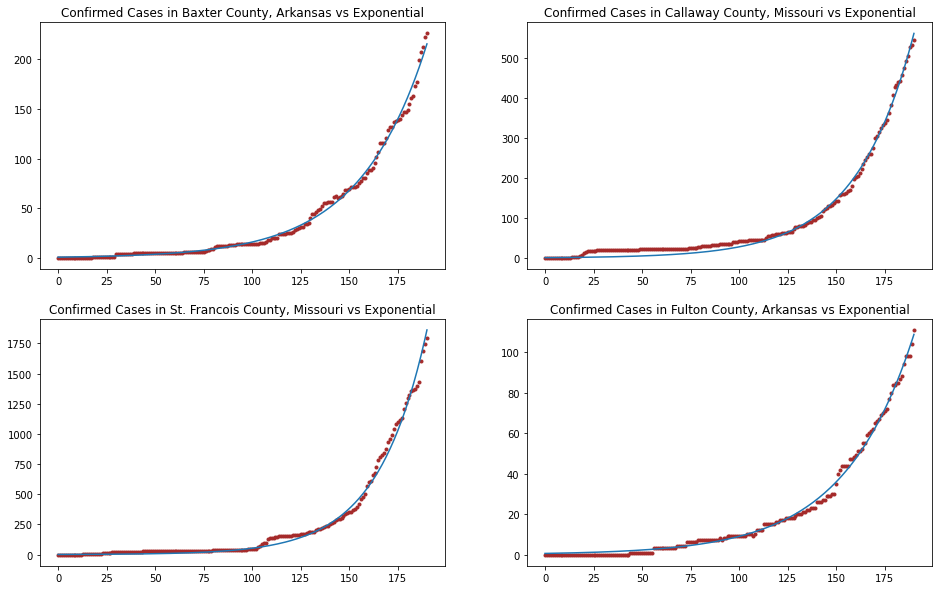

In [10]:
util.graph_examples(curves, ts_col_name, {"Exponential": curves["Exponential"]},
                    mask=stats['Exp_R^2'] >= r2_thresh)

## Time series that are better explained by logistic growth

Let's look at some examples where logistic growth (with a single
instance of the logistic function) produces a good fit, while an
exponential growth model does not.

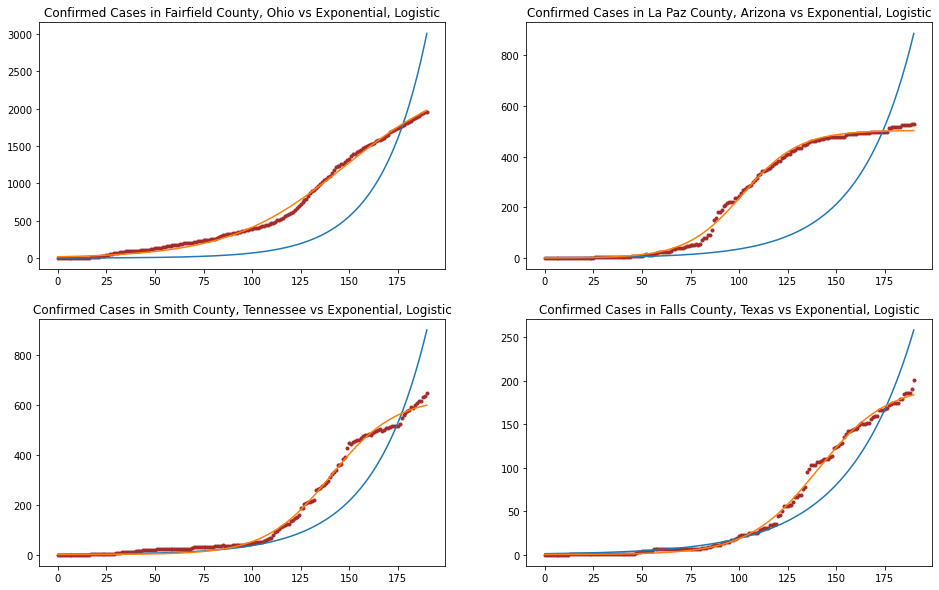

In [11]:
mask = (stats['Log_R^2'] >= r2_thresh) & (stats['Exp_R^2'] < 0.95)
util.graph_examples(curves, ts_col_name, 
                    {"Exponential": curves["Exponential"],
                     "Logistic": curves["Logistic"]},
                    mask=mask)

## Time series that are better explained by dual logistic functions

Let's examine cases where a mixture of two logistic growth models explains
the data better than a single logistic growth model.

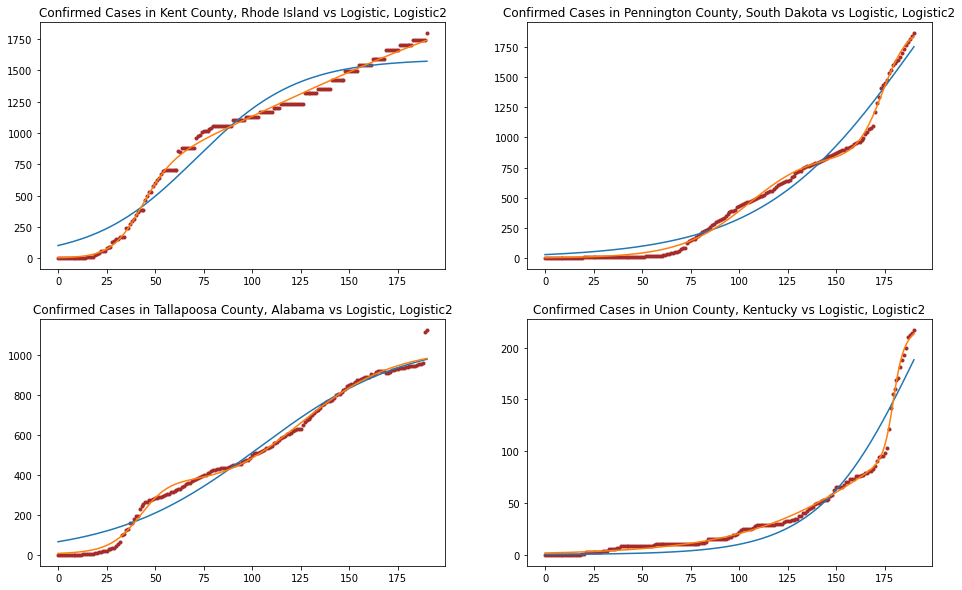

In [12]:
mask = stats['Log2_R^2'] - stats['Log_R^2'] >= 0.01
#graph_examples(mask, {"Logistic": logistic, "Logistic2": logistic2}, num_to_pick=10)
util.graph_examples(curves, ts_col_name, 
                    {"Logistic": curves["Logistic"],
                     "Logistic2": curves["Logistic2"]},
                    mask=mask)

## Time series where recent data looks like a straight line

Many of the dual-logistic curves have low values for the rate of the
second logistic function, indicating a curve where the later parts of the
curve look more like a straight line. 
Across the entire data set, what models have logistic rate2 near zero?

In [13]:
small_rate2_mask = (stats['Log2_R^2'] >= r2_thresh) & (params["Log2_Rate2"] < 5e-2)
params[small_rate2_mask][metadata_cols + [c for c in params.columns if c.startswith("Log2")]]

,State,County,Population,Log2_Max1,Log2_Rate1,Log2_Offset1,Log2_Max2,Log2_Rate2,Log2_Offset2,Log2_Switch_Begin,Log2_Switch_End
FIPS,,,,,,,,,,,
1001,Alabama,Autauga,55869,1522.318450,0.070265,96.234191,1601.552878,0.042286,134.537067,4.375111,58.299737
1005,Alabama,Barbour,24686,561.814750,10.000000,188.706987,921.779486,0.046162,105.029521,0.000000,191.000000
1007,Alabama,Bibb,22394,680.624634,0.041359,143.316933,711.522237,0.036683,143.316788,10.000067,19.999944
1009,Alabama,Blount,57826,5544.370981,6.230106,144.279760,1296.999375,0.049451,144.184437,13.405221,14.708308
1011,Alabama,Bullock,10101,789.349016,10.000000,191.000000,879.300134,0.016236,144.755912,66.555675,65.555675
...,...,...,...,...,...,...,...,...,...,...,...
55119,Wisconsin,Taylor,20343,167.651500,0.982754,163.089363,169.145621,0.048746,163.042519,9.999316,20.002054
55121,Wisconsin,Trempealeau,29649,711.602746,9.991508,190.910058,630.721762,0.015345,115.703817,114.486237,133.322700
55135,Wisconsin,Waupaca,50990,1000.678684,0.149449,160.054051,1061.104452,0.043244,160.047821,9.999183,20.001231


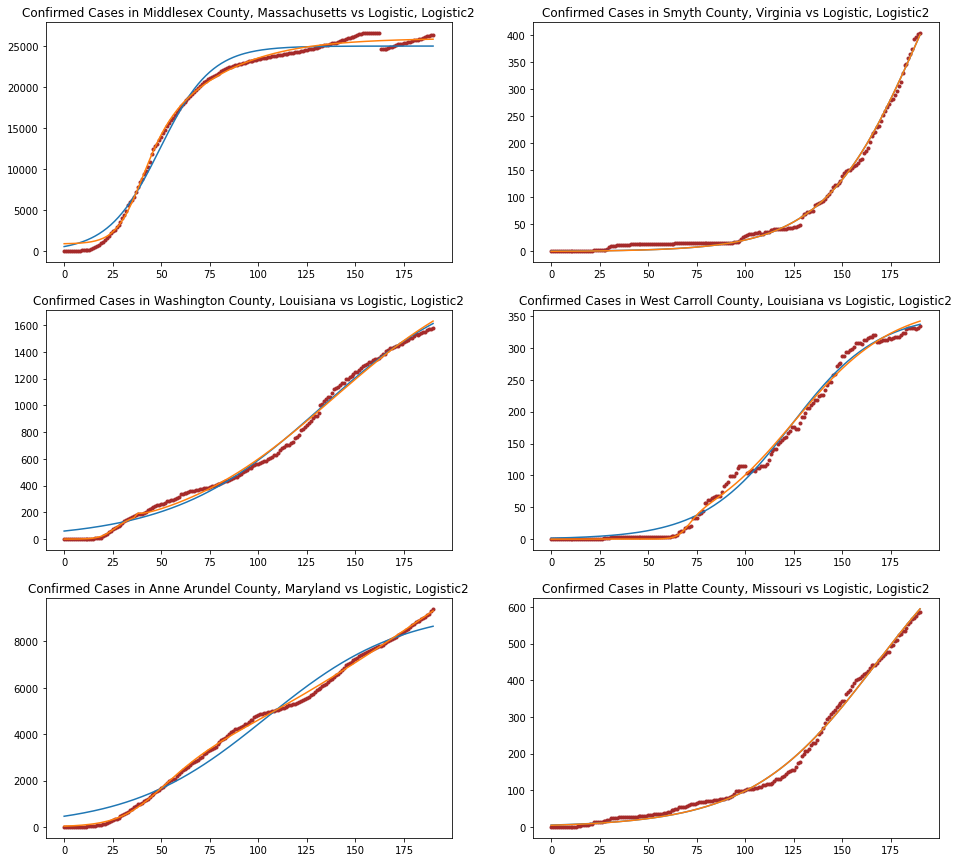

In [14]:
# Show some examples of these cases where Rate2 is small
util.graph_examples(curves, ts_col_name, 
                    {"Logistic": curves["Logistic"],
                     "Logistic2": curves["Logistic2"]},
                    mask=small_rate2_mask,
                    num_to_pick=6)

## Time series that can explained by steep logistic growth

Look at counties for which the rate for the single-logistic-curve fit is large. 
A high rate corresponds to a "steep" instance of the logistic function that 
transisitions abruptly between different regimes.

In [15]:
large_rate_mask = (
    (stats['Log_R^2'] >= r2_thresh) 
    & (params["Log_Rate"] > 2e-1))
params[large_rate_mask][metadata_cols + [c for c in params.columns 
                                         if (c.startswith("Log")
                                             and not c.startswith("Log2"))]]

,State,County,Population,Log_Max,Log_Rate,Log_Offset
FIPS,,,,,,
12067,Florida,Lafayette,8422,1198.173864,0.543980,156.526246
30071,Montana,Phillips,3954,111.732039,0.382474,154.534951
48105,Texas,Crockett,3464,160.453207,0.212432,129.448311
48169,Texas,Garza,6229,101.688876,0.207747,128.420931
48283,Texas,La Salle,7520,363.080686,0.424580,128.675243


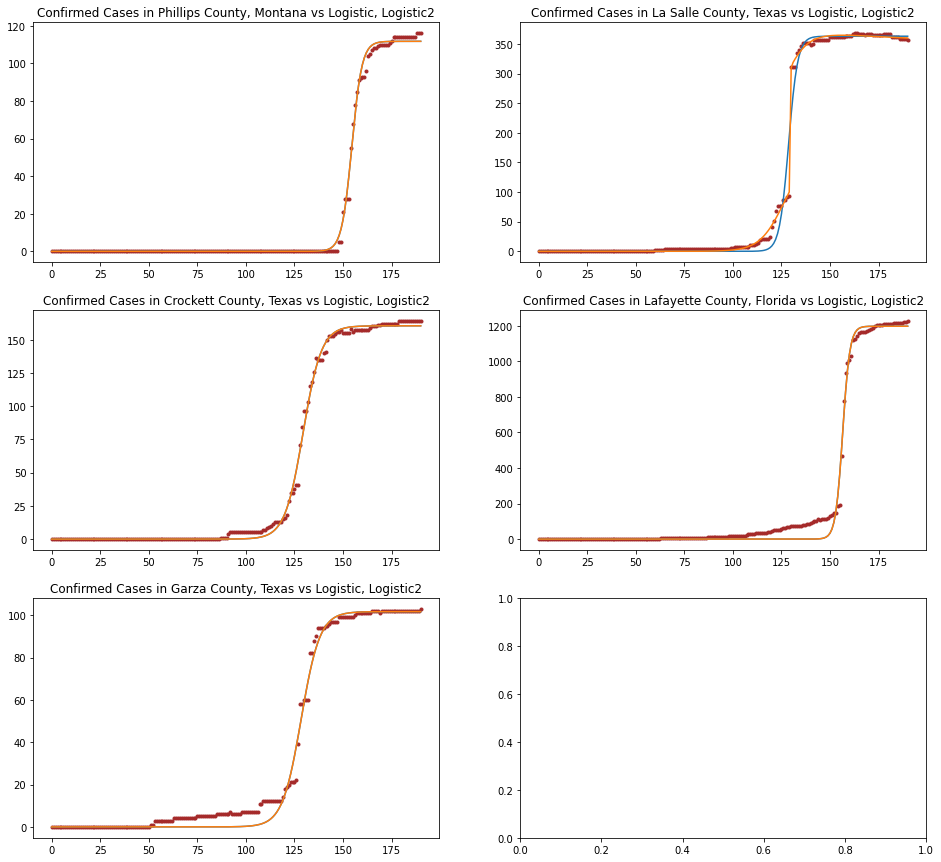

In [16]:
# Show some examples of these cases where Rate is large
util.graph_examples(curves, ts_col_name, 
                    {"Logistic": curves["Logistic"],
                     "Logistic2": curves["Logistic2"]},
                    mask=large_rate_mask,
                    num_to_pick=10)

## Time series that appear to be in the early phases of logistic growth

In [17]:
early_mask = (
    (stats['Log_R^2'] >= r2_thresh) & (params["Log_Offset"] > 80))
params[early_mask][metadata_cols + [c for c in params.columns 
                                    if (c.startswith("Log") and not c.startswith("Log2"))]]

,State,County,Population,Log_Max,Log_Rate,Log_Offset
FIPS,,,,,,
1001,Alabama,Autauga,55869,1590.052584,0.039488,129.980760
1003,Alabama,Baldwin,223234,4865.445687,0.065441,137.479038
1005,Alabama,Barbour,24686,679.404448,0.043202,112.873994
1007,Alabama,Bibb,22394,709.823846,0.036820,143.160423
1009,Alabama,Blount,57826,1296.922046,0.049456,144.181304
...,...,...,...,...,...,...
55133,Wisconsin,Waukesha,404198,7596.966425,0.040493,148.938469
55135,Wisconsin,Waupaca,50990,1059.964163,0.043297,159.989806
55141,Wisconsin,Wood,72999,681.636872,0.053093,157.467942


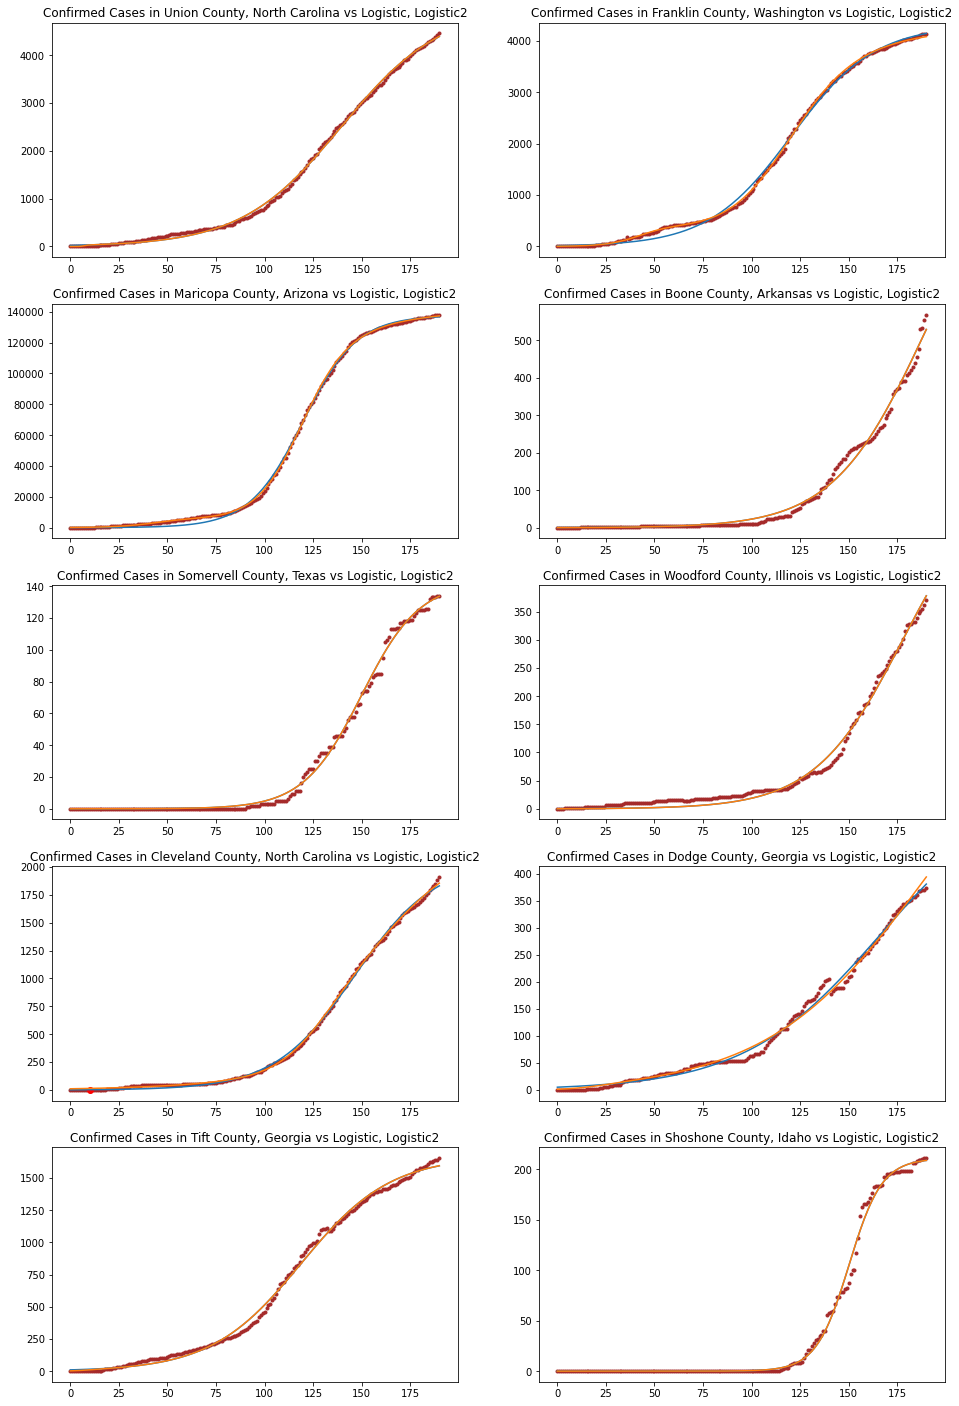

In [18]:
# Graphs of counties for which the logistic curve fit is currently
# in the early phases of logistic growth
util.graph_examples(curves, ts_col_name, 
                    {"Logistic": curves["Logistic"],
                     "Logistic2": curves["Logistic2"]},
                    mask=early_mask,
                    num_to_pick=10)

## Time series for counties with high population

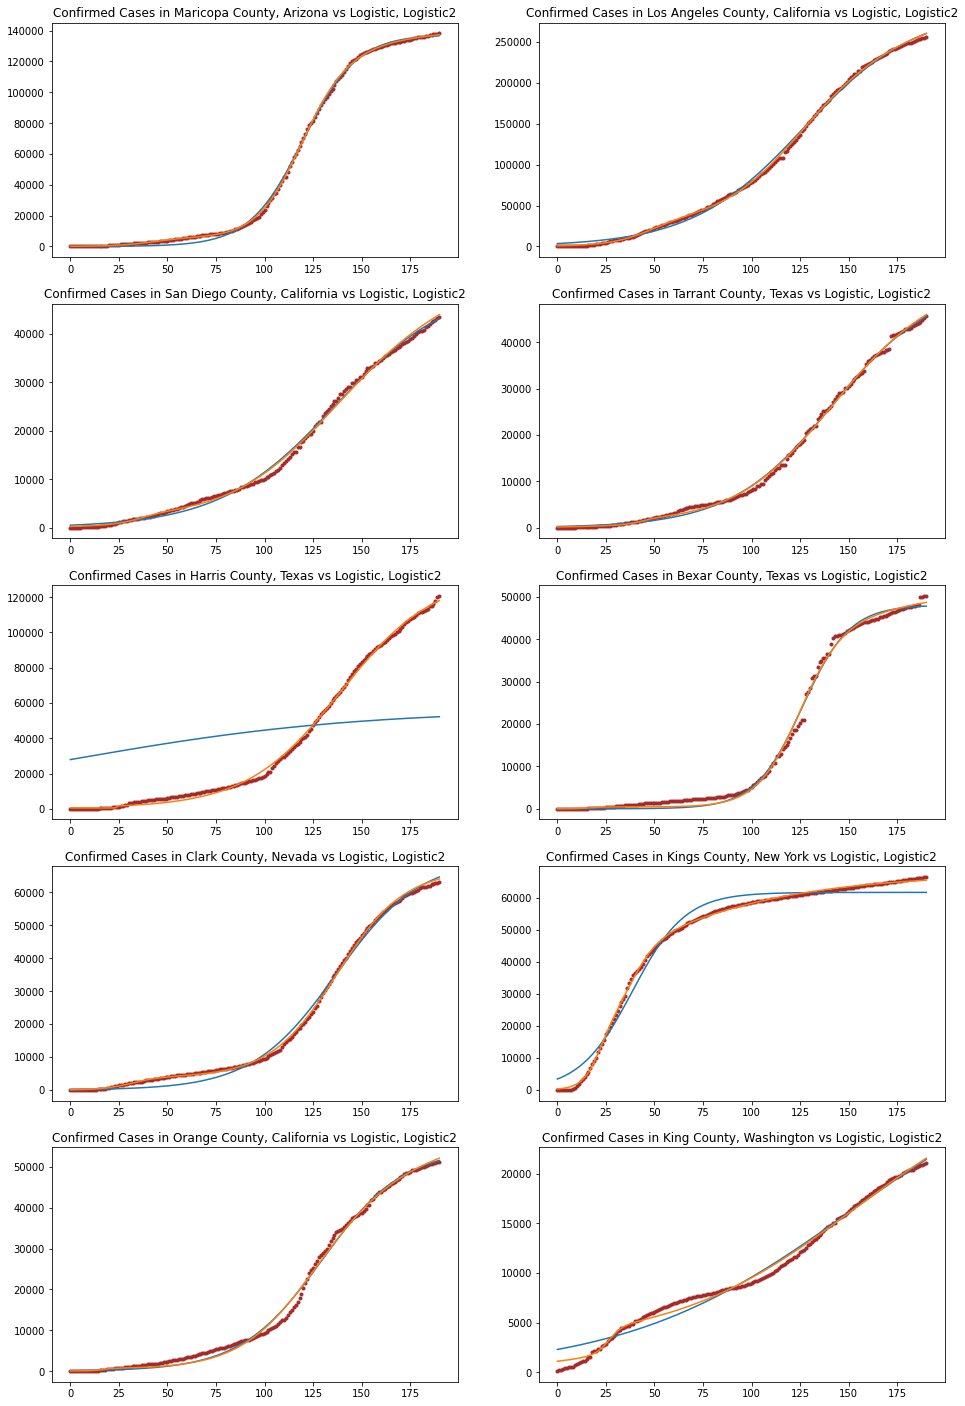

In [19]:
util.graph_examples(curves, ts_col_name, 
                    {"Logistic": curves["Logistic"],
                     "Logistic2": curves["Logistic2"]},
                    mask=curves["Population"] > 2e6,
                    num_to_pick=10)

## Time series that  *not* explained by any of our curves

In [20]:
non_fitting_mask = (stats["Exp_R^2"] < 0.99) & (stats["Log_R^2"] < 0.99) & (stats["Log2_R^2"] < 0.99)
stats[non_fitting_mask]

,State,County,Population,Exp_R^2,Log_R^2,Log2_R^2
FIPS,,,,,,
1019,Alabama,Cherokee,26196,0.843688,0.989063,0.989018
1025,Alabama,Clarke,23622,0.700961,0.980828,0.980773
1037,Alabama,Coosa,10663,0.475470,0.971517,0.981308
1041,Alabama,Crenshaw,13772,0.731080,0.984341,0.984184
1059,Alabama,Franklin,31362,0.166721,0.981634,0.983727
...,...,...,...,...,...,...
56023,Wyoming,Lincoln,19830,0.828681,0.979566,0.979567
56025,Wyoming,Natrona,79858,0.593748,0.985147,0.987695
56033,Wyoming,Sheridan,30485,0.983782,0.974157,0.973101


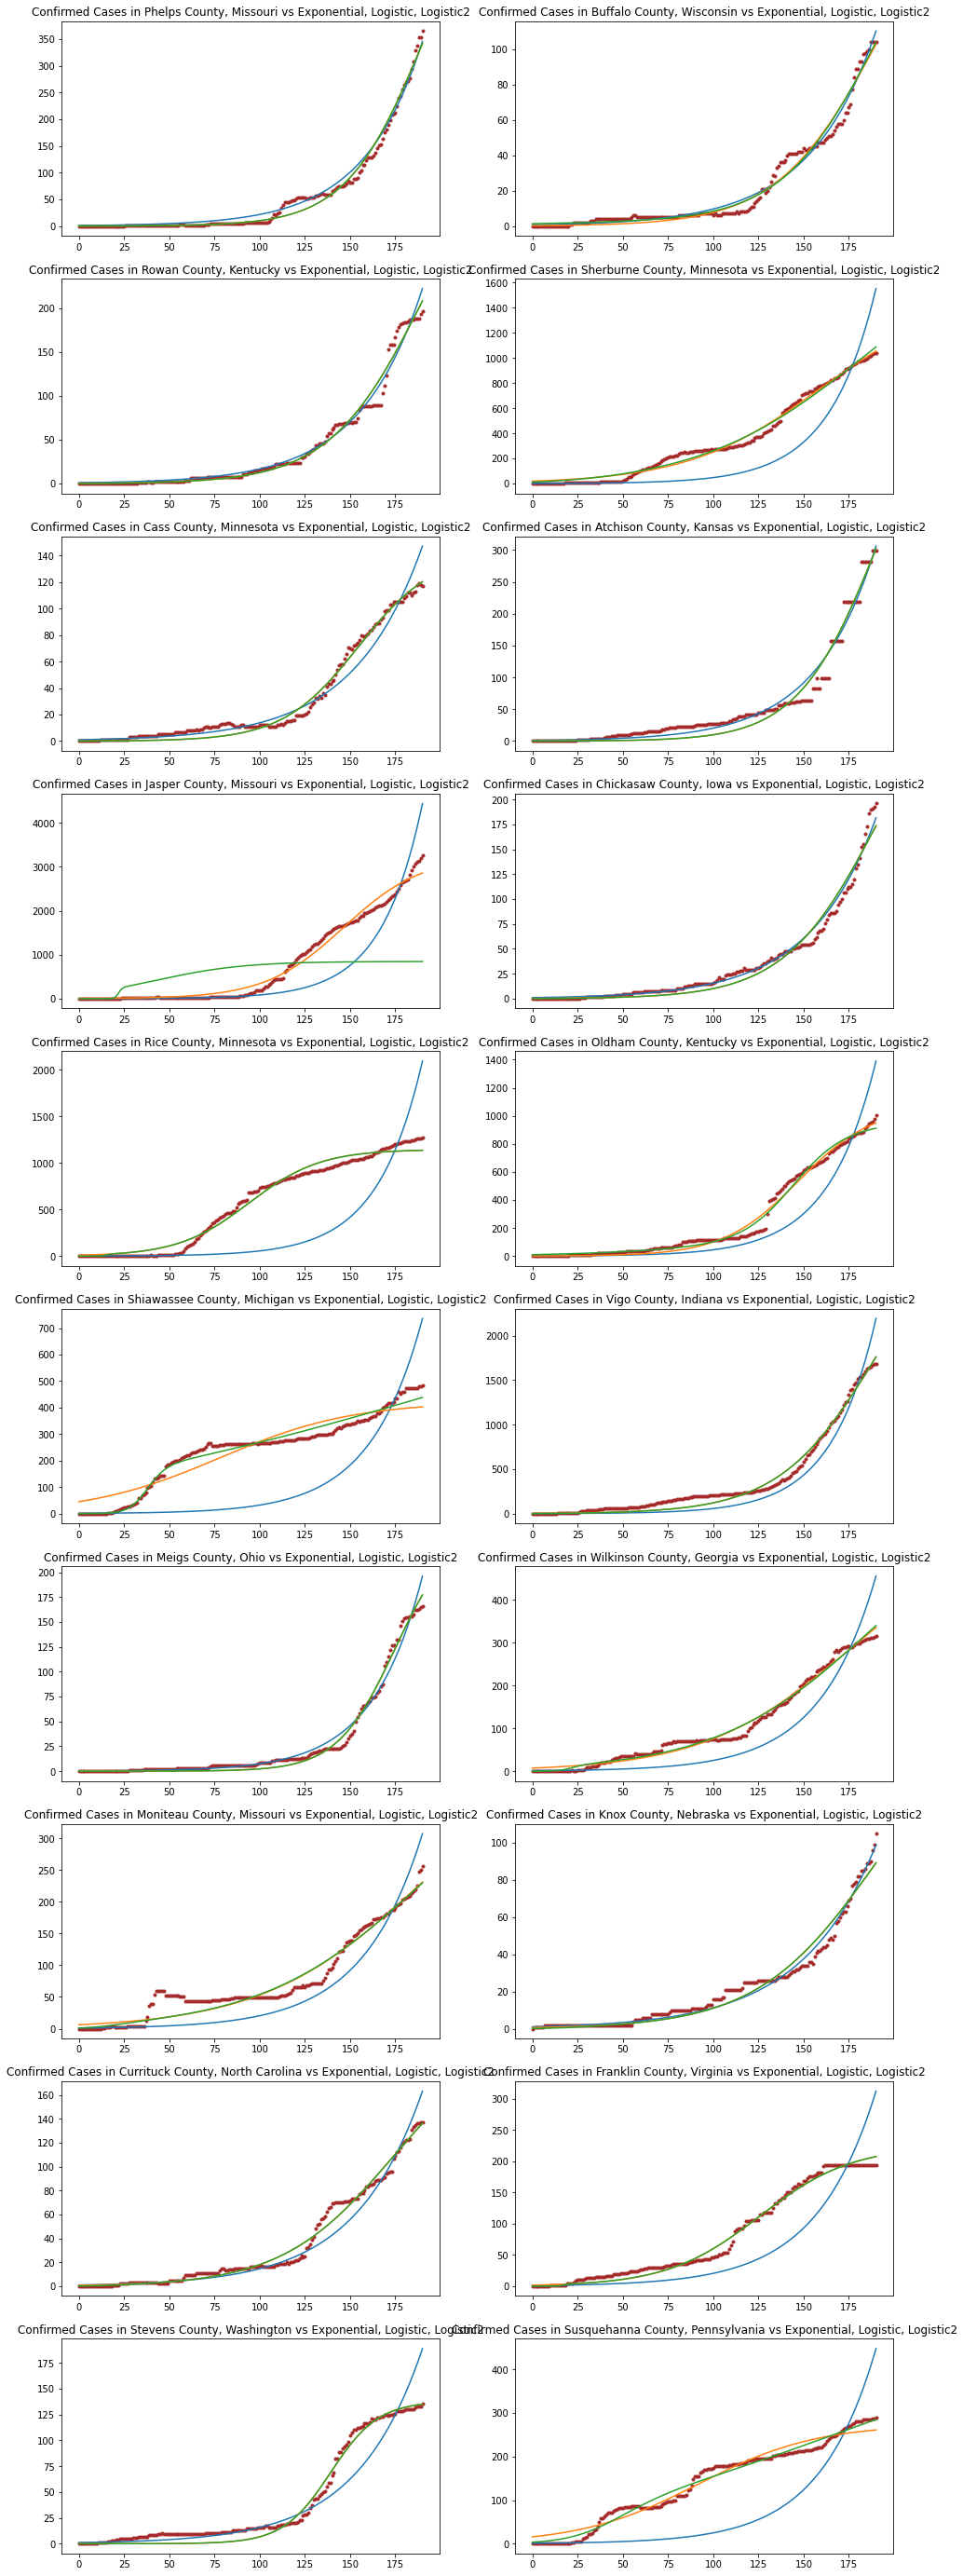

In [21]:
util.graph_examples(curves, ts_col_name, 
                    {"Exponential": curves["Exponential"],
                     "Logistic": curves["Logistic"],
                     "Logistic2": curves["Logistic2"]},
                    mask=non_fitting_mask,
                    num_to_pick=20)